# Tucker Model

#### Pseudo code
* create individuals
* assign status
* for (at=1:num.timesteps) { <br>
    infection <br>
    calculate number of acts <br>
    determine who has an act with whom (ie construct "edgelist") <br>
    limit edgelist to discordant pairs <br>
    determine infections <br>
    do bookkeeping for infections <br>
    recovery <br>
    identify infecteds <br>
    determine recoveries <br>
    do bookkeeping for recoveries <br>
}

In [13]:
# Libraries/packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import optimize

In [14]:
#fix random seed for reproducibility

np.random.seed(seed=42)

### Camp Structure

In [15]:
Nb = 8100          # Number of people in isoboxes.
mub = 10           # Isoboxes mean occupancy (people).
hb = Nb / mub      # Number of isoboxes. 
iba = 0.5          # Proportion of area covered by isoboxes.

Nt = 10600         # Number of people in tents.
mut = 4            # Tents occupancy of (people).
ht = 10600 / mut   # Number of tents.

fblocks = np.array([1,1])   # initial sectoring. Divide camp into (nxn) grid, each with its own food line.
N = Nb + Nt                 # Total population.


### Emperical Age and Sex Distribution

In [16]:
path_to_file = 'age_and_sex.csv'            # Observed data.
age_and_sex = pd.read_csv(path_to_file)     # Data frame. V1 = age, V2 is sex (1 = male?, 0  = female?).
#type(age_and_sex)

# Remove "Unamed column" and preview.
age_and_sex = age_and_sex.loc[:, ~age_and_sex.columns.str.contains('^Unnamed')]
age_and_sex.head() 

,V1,V2
0,2.1,1
1,25.6,0
2,23.6,0
3,49.6,1
4,28.6,0


In [17]:
print(age_and_sex.describe())     # Summary stats.
age_and_sex = age_and_sex.values  # dataframe to 2D array.
#type(age_and_sex)
#age_and_sex[:5,]

                 V1            V2
count  12883.000000  12883.000000
mean      25.615687      0.541877
std       16.570576      0.498263
min        0.100000      0.000000
25%       14.700000      0.000000
50%       24.600000      1.000000
75%       35.100000      1.000000
max       89.700000      1.000000


### Transmission parameters

In [18]:
# Infection
twh = 0.5   # Probability of infecting each person in your household per day.
aip = 0.1   # Probability of infecting each person you meet per meeting (Fang et al.)
tr = 1      # Initial transmission reduction (relative to assumed per contact transmission rate, outside household only).

### Other parameters

In [19]:
siprob = 0        # Probability of spotting symptoms, per person per day.
clearday = 7      # Days in quarantine after no virus shedding (i.e., recovery).
pac = 0.179       # Permanently asymptomatic cases (Mizumoto et al 2020 Eurosurveillance).
ss = 0.20         # Realtive strength of interaction between different ethnicities.

### Initial movement parameters
Note that the initial assumption is that
everyone uses the larger radius some proportion of the time, which is
__NOT__ the same as assuming that some people always use the larger radius,
Nonetheless, I am setting the proportion equal to the number of males age 10-50 in the population.

In [20]:
lr1 = 0.02       # Smaller movement radius. Range around their household during lockdown or females and individuals age < 10.
lr2 = 0.1        # Larger movement radius. ie. Pople who violate lockdown enforcement or males over age 10.
lrtol = 0.02     # Scale interactions - two people with completely overlapping rages with this radius interact once per day

### Create population matrix (pop)
Columns:
0. Home number
1. Disease state: 0 = susceptible, 1 = exposed, 2 = presymptomatic, 3 = symptomatic, 4 = mild, 5 = severe, 6 = recovered. Similar states in quarentine are the same plus seven. In other words, this is a categorical variable with values between 0 and 13 inclusive.
2. Days to symptoms for this person
3. Days passed in current state
4. Whether this person will be asymptomatic
5. Age
6. Male: = 1 if male.
7. Chronic: = 1 if chronic disease?
8. Wanderer (Uses the larger radius).

pop is $N \times 9$

#### Columns 0-1 (House number and disease state)

- Randomly assign each person to a household (rN).
- Draw a sample from uniform distribution between 1-810 (hb). Meaning we chose a random isobox.
- Then repeat that 8100 (Nb) times. AKA assign each person to an isobox.
- Do the same for the tent group.
- Indices (ui) of the unique array that reconstruct the input array (rN).
- The number of inidces should equal total population (N).
- Note: Household column is not the huse itself but the index of that house hold.
- Start each person as susceptible (col 1 = 0).
- Randomly assign one person to be exposed to the virus (pop[someindex,1]=1).

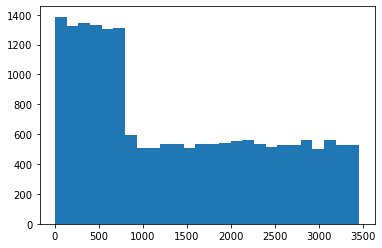

In [21]:
rN = np.concatenate((np.ceil(hb*np.random.uniform(0,1,Nb)), hb+np.ceil(ht*np.random.uniform(0,1,Nt)))) 
plt.hist(rN,bins='auto')
plt.show()

U,ui = np.unique(rN, return_inverse=True)  # ui - indices from the unique sorted array that would reconstruct rN
assert U[ui].all() == rN.all()

pop_2 = np.column_stack((np.sort(ui), np.zeros((ui.shape)))) # Size N x 2 (18700 x 2).
assert pop_2.shape==(18700, 2)

pop_2[np.random.randint(0,N),1] = 1

In [22]:
np.shape(pop_2)

(18700, 2)

In [23]:
np.shape(ui)

(18700,)

In [24]:
np.shape(rN)

(18700,)

In [25]:
np.shape(U)

(3414,)

In [26]:
ui[:10]

array([303, 770, 592, 484, 126, 126,  47, 701, 486, 573], dtype=int64)

In [27]:
np.subtract(rN[:10],1).astype(int)

array([303, 770, 592, 484, 126, 126,  47, 701, 486, 573])

In [28]:
np.unique(pop_2[:][1])

array([0.])

In [29]:
np.min(rN)

1.0

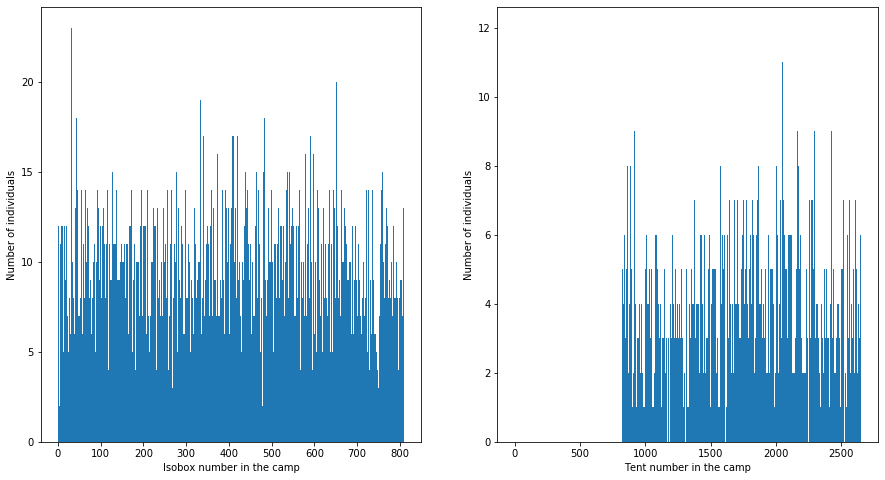

In [30]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Number of individuals')
ax1.set_xlabel('Isobox number in the camp')
ax1.hist(rN[:Nb+1], bins=np.arange(1,hb+1))
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Number of individuals')
ax2.set_xlabel('Tent number in the camp')
ax2.hist(rN[Nb+1:], bins=np.arange(1,ht+1))
plt.show()

#### Columns 2-4 (symptoms)
- Col 2: Days to first symptoms (if they develop symptoms) for each person, following (Backer et al. 2020 Eurosurveillance)
- Col 3: Days passed in current state, 0 for now.
- Col 4: Whether this person will be asymptomatic.

In [31]:
k = (2.3/6.4)**(-1.086)
L = 6.4 / (math.gamma(1 + 1/k))
pop_5 = np.column_stack( (pop_2, k*np.random.weibull(L,(N,1)), np.zeros((N,1)), np.random.uniform(0,1,N)<pac*(N/(N-300))) )
assert pop_5.shape==(18700, 5)

In [32]:
np.shape(np.random.uniform(0,1,N)<pac*(N/(N-300)))

(18700,)

#### Columns 5-6 (Age and sex)
- Get N random samples from the distribution in the observed data with repetition.
- Assign age and sex following the observed distribution in the camp.

I believe I treated the age and sex distributions as separate whereas I think I should treat
the age and sex for a give individual together (if that makes sense?).
i.e. I got the sex and age samples on their own where as the original Matlab code gets them
from the age-sex pairs: age_and_sex(randsample(size(age_and_sex,1),N,true),:)

However, the distributions seem equal in the original program and here.

Billy: I have editted here by drawing samples from rows 

In [33]:
age_and_sex_N=age_and_sex[np.random.randint(age_and_sex.shape[0], size=N)]

In [34]:
np.shape(age_and_sex_N)

(18700, 2)

In [35]:
# Is this approach correct?
pop_7 = np.column_stack((pop_5,
                       age_and_sex_N[:,0],
                       age_and_sex_N[:,1]))
assert pop_7.shape==(18700, 7)

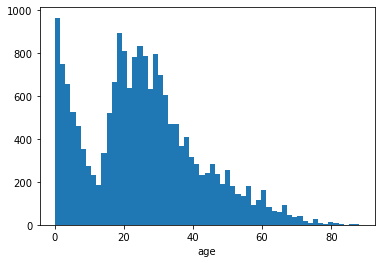

In [36]:
plt.hist(pop_7[:,5],bins='auto')
plt.xlabel('age')
plt.show()

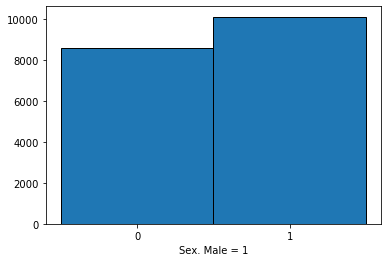

In [37]:
plt.hist(pop_7[:,6], bins=[-0.5,0.5,1.5], ec="k")
plt.xticks((0,1))
plt.xlabel('Sex. Male = 1')
plt.show()

#### Column 7-8 (Chronic States and wanderers)
- Matching the relationship between age and chronic states in the data.
- Males over the age of ten are wanderers.

There is a bug somewhere in the lambda function that makes the minimum (xopt) is too small compared to the original program (~1.62) which causes (rchron) to be 1 for all individuals ... which then makes the asymptomatic column all equal to zero.

Would it be sensible to put an upper limit on the age when defining wanderers? ie. 10 < age < 60

Billy: I am guessing the original equation is trying to find the xopt that makes myfunction-N equals to 0 according to the plot below because otherwise fmin will take the value xopt way to the left. But yeah I am confused in how this equation is produced here - we are aiming to assing 300 people or so with chronic conditions right?

Gonzalo: Fixed. We get ~300 counts.

In [38]:
myfunction = lambda x: np.absolute(300-np.sum((1+np.exp(-(x-11.69+.2191*pop_7[:,5]-0.001461*pop_7[:,5]**2))**(-1))))-N
xopt = optimize.fsolve(myfunction, x0=[2])
print(xopt)

[1.56374426]


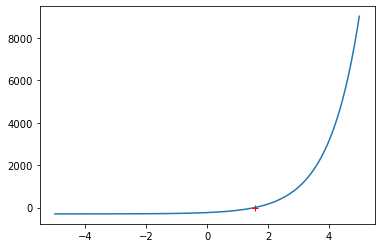

In [39]:
x_s= np.linspace(-5, 5, 201)
y=[myfunction(x) for x in x_s]
plt.plot(x_s, y,xopt,myfunction(xopt),'r+')
plt.show()

In [40]:
#rchron=myfunction(xopt)
rchron = (1+np.exp(-(xopt-11.69+.2191*pop_7[:,5]-0.001461*pop_7[:,5]**2)))**(-1)
chroncases = (np.random.uniform(np.min(rchron),1,N) < rchron) 

pop_8 = np.column_stack( (pop_7, chroncases))
assert pop_8.shape==(18700, 8)

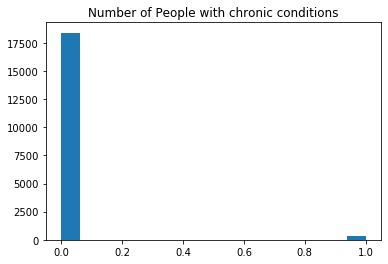

In [41]:
chroncases[np.where(chroncases == 1)]
plt.hist(chroncases.astype(int),bins='auto')
plt.title('Number of People with chronic conditions')
plt.show()

303


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


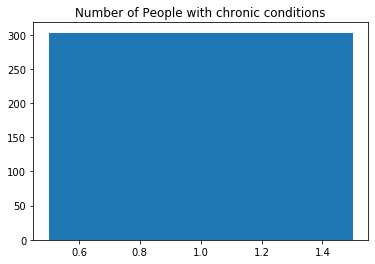

In [42]:
print(np.sum(chroncases))
plt.hist(chroncases[np.where(chroncases == 1)],bins='auto')
plt.title("Number of People with chronic conditions")
plt.show()

In [43]:
# Ensure that people with chronic conditions are not asymptomatic, and correct number of asymptomatics above.
# In other words, if chronic conditions = 1 then not asymptomatic.
pop_8[ pop_8[:,7] == 1,4 ] = 0 
pop_9 = np.column_stack( (pop_8, np.logical_and([pop_8[:,6] == 1], [10 <= pop_8[:,5]]).transpose() ) ) # Wanderers
assert pop_9.shape==(18700, 9)

### Create households
- pph is people per household
- hhloc are the x and y coordinates of each household
- Assign household locations, with isoboxes occupying a square in the center

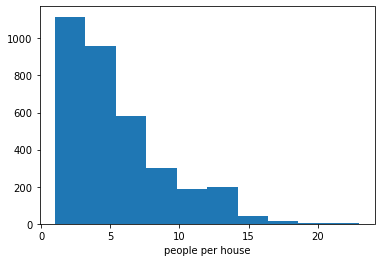

3414
3460.0
3413.0


In [44]:
pph = np.bincount(ui)
maxhh = pph.size

plt.hist(pph)
plt.xlabel('people per house')
plt.show()

print(maxhh)  # This number is different than total number of house holds
print(ht+hb)
print(pop_9[-1,0]) # Index of last house, so house number is index +1

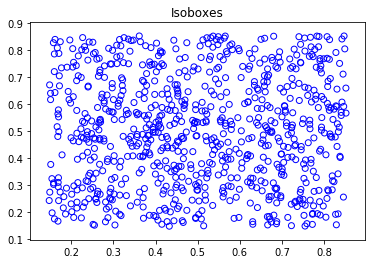

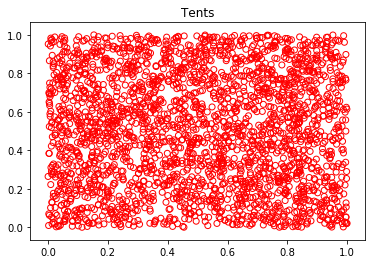

In [45]:
# Assign x and y coordinates to isoboxes (there are hb total isoboxes). 
hhloc1 = 0.5*(1-np.sqrt(iba)) + np.sqrt(iba)*np.random.uniform(0,1,(int(hb),2))
plt.scatter(hhloc1[:,0], hhloc1[:,1],facecolors='none', edgecolors='b')
plt.title('Isoboxes')
plt.show()

# Repeat for tents.
#hhloc2 = np.random.uniform(0,1,(int(ht),2))
hhloc2 = np.random.uniform(0,1,(int(pop_9[N-1,0]-pop_9[Nb-1,0]),2)) # Note: Nb-1 and N-1 to account for zero-indexing.
plt.scatter(hhloc2[:,0], hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

assert (hhloc1.shape[0]+hhloc2.shape[0] == maxhh)

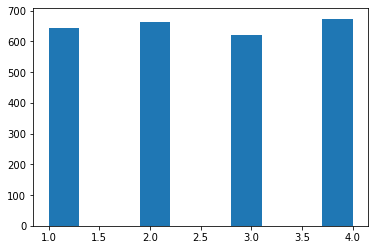

In [46]:
# Randomly move tents to the edges of the camp. Assign weights to them.
hhloc2w = np.ceil(4*np.random.uniform(0,1,(int(pop_9[N-1,0]-pop_9[Nb-1,0]),1)))
plt.hist(hhloc2w)
plt.show()

assert len(hhloc2w) == hhloc2.shape[0]

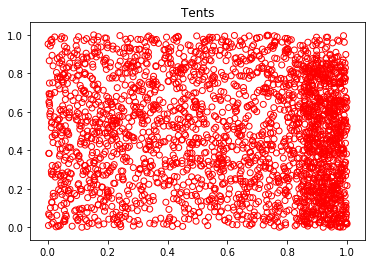

In [47]:
# This block moves some tents to the right edge.

shift = 0.5*(1-np.sqrt(iba))
# print(shift)
# print(1-shift)

# temp = np.copy(hhloc2) # Make deep copy for testing
# temp[np.where(hhloc2w==1),0] = 1+shift*(hhloc2[np.where(hhloc2w == 1),0]-1)
# temp[np.where(hhloc2w==1),1] = (1-shift)*hhloc2[np.where(hhloc2w == 1),1]
#plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==1),0] = 1+shift*(hhloc2[np.where(hhloc2w == 1),0]-1)
hhloc2[np.where(hhloc2w==1),1] = (1-shift)*hhloc2[np.where(hhloc2w == 1),1]

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

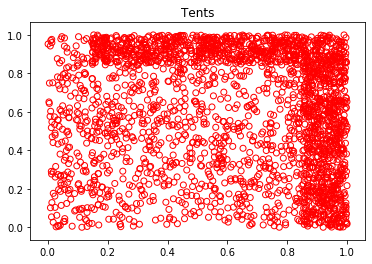

In [48]:
# This block moves some tents to the upper edge.

# temp[np.where(hhloc2w==2),0] = hhloc2[np.where(hhloc2w == 2),0]*(1-shift)+shift
# temp[np.where(hhloc2w==2),1] = 1+shift*(hhloc2[np.where(hhloc2w == 2),1]-1)
# plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==2),0] = hhloc2[np.where(hhloc2w == 2),0]*(1-shift)+shift
hhloc2[np.where(hhloc2w==2),1] = 1+shift*(hhloc2[np.where(hhloc2w == 2),1]-1)

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

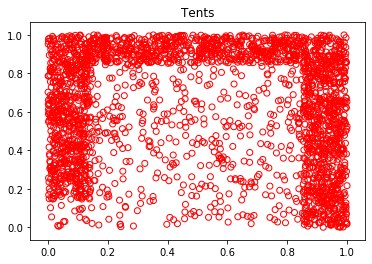

In [49]:
# This block moves some tents to the left edge.

# temp[np.where(hhloc2w==3),0] = shift*hhloc2[np.where(hhloc2w == 3),0]
# temp[np.where(hhloc2w==3),1] = hhloc2[np.where(hhloc2w == 3),1]*(1-shift)+shift
#plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==3),0] = shift*hhloc2[np.where(hhloc2w == 3),0]
hhloc2[np.where(hhloc2w==3),1] = hhloc2[np.where(hhloc2w == 3),1]*(1-shift)+shift

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

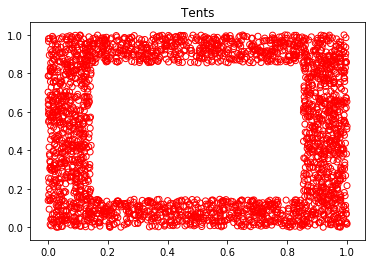

In [50]:
# This block moves some tents to the bottom edge.

# temp[np.where(hhloc2w==4),0] = (1-shift)*hhloc2[np.where(hhloc2w == 4),0]
# temp[np.where(hhloc2w==4),1] = shift*hhloc2[np.where(hhloc2w == 4),1]
# plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==4),0] = (1-shift)*hhloc2[np.where(hhloc2w == 4),0]
hhloc2[np.where(hhloc2w==4),1] = shift*hhloc2[np.where(hhloc2w == 4),1]

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

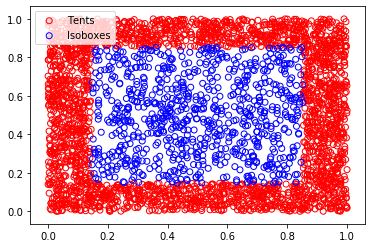

In [51]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r', label='Tents')
ax1.scatter(hhloc1[:,0],hhloc1[:,1],facecolors='none', edgecolors='b', label='Isoboxes')
plt.legend(loc='upper left');
plt.show()

hhloc = np.vstack((hhloc1,hhloc2)) 
assert hhloc.shape[0] == maxhh

### POSITION TOILETS
- Toilets position make an evely spaced $nx \times ny$ grid throughout the camp.
- Create where 1 indicates that households share the same toilet.

In [52]:
def assignBlock(hhlocc,maxhh,blocks):
    """
    Out
    num: Assign a block to a household (ie. toilet block or food line)
    shared: A Matrix of shared blocks at the household level.
    """
    grid1 = np.sum(np.outer(hhloc[:,0],np.ones((1,blocks[0])))>np.outer(np.ones((maxhh,1)),np.arange(1,blocks[0]+1)/blocks[0]),1)
    grid2 = np.sum(np.outer(hhloc[:,1],np.ones((1,blocks[1])))>np.outer(np.ones((maxhh,1)),np.arange(1,blocks[1]+1)/blocks[1]),1)
    num = grid2*blocks[0]+grid1+1
    TEMP = np.outer(num,np.ones((1,len(num))))
    shared = (TEMP.T == TEMP) - np.eye(maxhh)
    return [num,shared]

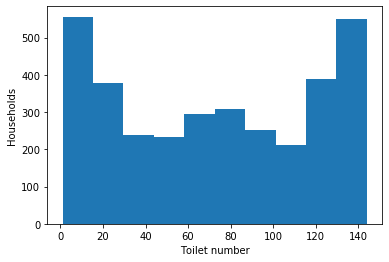

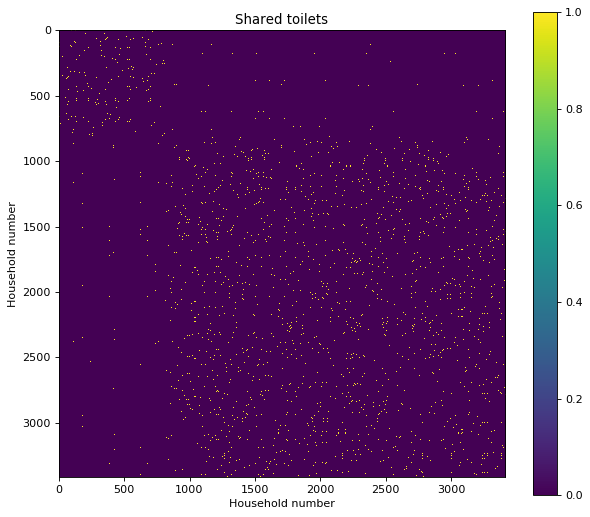

In [53]:
nx = 12
ny = 12
tblocks = np.array([nx,ny])       # Grid dimensions.
tgroups = tblocks[0]*tblocks[1]   # Number of blocks in the grid.
tu = N/tgroups                    # ~ people / toilet

# Assign a toilet number to a household nad what.
[tnum,tshared] = assignBlock(hhloc,maxhh,tblocks)
assert np.max(tnum) == np.prod(tblocks)
assert tshared.shape == (maxhh,maxhh)

plt.hist(tnum)
plt.ylabel('Households')
plt.xlabel('Toilet number')
plt.show()

fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(tshared)
plt.title('Shared toilets')
plt.xlabel('Household number')
plt.ylabel('Household number')
plt.colorbar()
plt.show()

### Create ethnic groups
- Households are assigned to ethnicities.
- Ethnic groups are spatially clustered and randomly positioned
- The distribution matches the distribution of people in the Moria data.
- Only ethnicities with > 50 people in the observed data included.

How do we account for ethnicities with < 50 peolpe?

In [54]:
# Number of people in each group.
Afghan = 7919 ; Cameroon = 149 ; Congo = 706 ;Iran = 107 ;Iraq = 83 ; Somalia = 442 ; Syria = 729
g = np.array([Afghan,Cameroon,Congo,Iran,Iraq,Somalia,Syria])  

# Im not sure what this number represents exactly. I believe its related to population but it does not equal sum(g).
totEthnic = 15327  
totEthnic == np.sum(g)

g = np.round(maxhh*g/totEthnic)              # Number of households per group.
g = np.random.choice(g,len(g),replace=False) # Randomize group order.

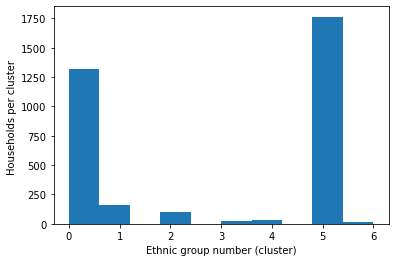

In [55]:
# Randomly chose a household (location), and assign an ethnicity to the n nearest households.

hhunass = np.column_stack((np.arange(0,maxhh), hhloc))   # Unassigned households. Firsto column is the index of the hh.
hheth = np.zeros((maxhh,1))                              # Ethnic households

for i in range(len(g)):
    gcen = hhunass[np.random.randint(hhunass.shape[0]),1:] # Chose an unassigned household as the group (cluster) centre.
    dfromc = np.sum((hhunass[:,1:]-np.tile(gcen,(hhunass.shape[0],1)))**2,1) # Squared distance to cluster centre.
    cloind = np.argsort(dfromc)                            # Get the indices of the closest households (cloind).
    hheth[hhunass[cloind[0:int(g[i])],0].astype(int)] = i  # Assign i-th ethnic group to those households.
    hhunass = np.delete(hhunass,cloind[0:int(g[i])],0)     # Remove those hoseholds (remove the i-th cluster/ethnic group)
    
plt.hist(hheth)
plt.ylabel('Households per cluster ')
plt.xlabel('Ethnic group number (cluster)')
plt.show()

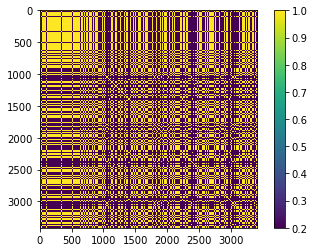

In [56]:
# Scale local interactions strength for ethnicities

# plt.imshow(np.tile(hheth,(1,len(hheth))))
# plt.colorbar()
# plt.show()

# plt.imshow( np.tile(hheth,(1,len(hheth))).T )
# plt.colorbar()
# plt.show()

ethmatch = ( np.tile(hheth,(1,len(hheth))) ==  np.tile(hheth,(1,len(hheth))).T )
ethcor = ethmatch+ss*(1-ethmatch)

plt.imshow( ethcor )
plt.colorbar()
plt.show()

### Create interaction rates

In [57]:
def make_obs_180420(fblocks,lr1,lr2,N,hhloc,maxhh,lrtol,ethcor):
    """
    fshared: matrix that indictes whether two households use the same food distribution center.
    lis: matrix that holds local interacton stregth between members of different households.
    tl: probability of transmission per local interaction
    tt: probability of transmission per regional interaction (i.e., 3x daily toilet visits,
    from either person before or person after)
    tg: probability of transmission per global interaction (i.e., 3x daily food lines, from either person before or 
    person after, but only 1/4 of people go to the food line each time to  collect for household).
    """
    # fgroups = np.prod([fblocks]) # Number of feeding groups.
    # fu = N/fgroups # Individuals per feeding group.
    
    # 1) Assign households to feeding blocks. Make matrix of shared feeding blocks at the household level.
    [fnum,fshared] = assignBlock(hhloc,maxhh,fblocks) 
    
    # 2) Compute interaction rates among households.
    # Distance matrix between households.
    hhdm = np.sqrt((np.tile(hhloc[:,0],(hhloc.shape[0],1)).T - np.tile(hhloc[:,0],(hhloc.shape[0],1)))**2 + 
                   (np.tile(hhloc[:,1],(hhloc.shape[0],1)).T - np.tile(hhloc[:,1],(hhloc.shape[0],1)))**2)  
    
    # 3) Compute the lens of shared area between households, scaled for the density
    # with which individuals occupy that lens (which decreases in proportion to
    # the area of the lens. Here, poeij is the density overlap between
    # individuals using radii i and j, respectively (but poeij=poeji).    
    poe11 = np.nan_to_num(np.real(2*lr1**2*np.arccos(hhdm/(2*lr1)) -
                    np.multiply(0.5*hhdm,np.sqrt(np.multiply((2*lr1-hhdm),(2*lr1+hhdm))))) / (math.pi**2*lr1**4))
    poe22 = np.nan_to_num(np.real(2*lr2**2*np.arccos(hhdm/(2*lr2)) -
                    np.multiply(0.5*hhdm,np.sqrt(np.multiply((2*lr2-hhdm),(2*lr2+hhdm))))) / (math.pi**2*lr2**4))
    poe12 = np.real(lr1**2*np.arccos( (hhdm**2+lr1**2-lr2**2) / 2*hhdm*lr1 ) +
                    lr2**2*np.arccos( (hhdm**2+lr2**2-lr1**2) / 2*hhdm*lr2 ) -
                    np.multiply(np.multiply(-hhdm+lr1+lr2,hhdm+lr1-lr2),np.multiply(hhdm-lr1+lr2,hhdm+lr1+lr2)))    
    poe12 = poe12 / (math.pi**2*lr2**2*lr1**2)
    np.fill_diagonal(poe12,0)
    
    # Scale to standard by which 2 people occupying the same circle with radius
    # lrtol have one interaction per day. Store in a 3-D array.    
    lis = np.multiply(math.pi*lrtol**2*np.dstack((poe11,poe12,poe22)),np.dstack((ethcor,ethcor,ethcor)))
    
    # % %SET LOCAL REGIONAL AND GLOBAL TRANSMISSION PROBABILITIES. This computes
    # % %the probability of transmission per encounter times the number of
    # % %encounters between individuals per day
    # % tl=aip*tr;                  %local
    # % tt=aip*tr*(2*3)/tu;         %toilet - assume possible transmission to person before or after
    # %                             %in line, 3 times per day
    # % tg=aip*tr*(2*3*(1/4))/fu;   %global - assume possible transmission to person before or after
    # %                             %in line, 3 times per day, but 1/4 of people go    
    
    return fshared, lis

C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in arccos
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in arccos
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


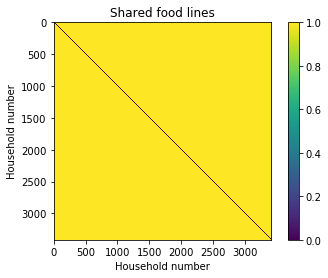

In [58]:
fshared, lis = make_obs_180420(fblocks,lr1,lr2,N,hhloc,maxhh,lrtol,ethcor)
plt.imshow(fshared)
plt.title('Shared food lines')
plt.xlabel('Household number')
plt.ylabel('Household number')
plt.colorbar()
plt.show()

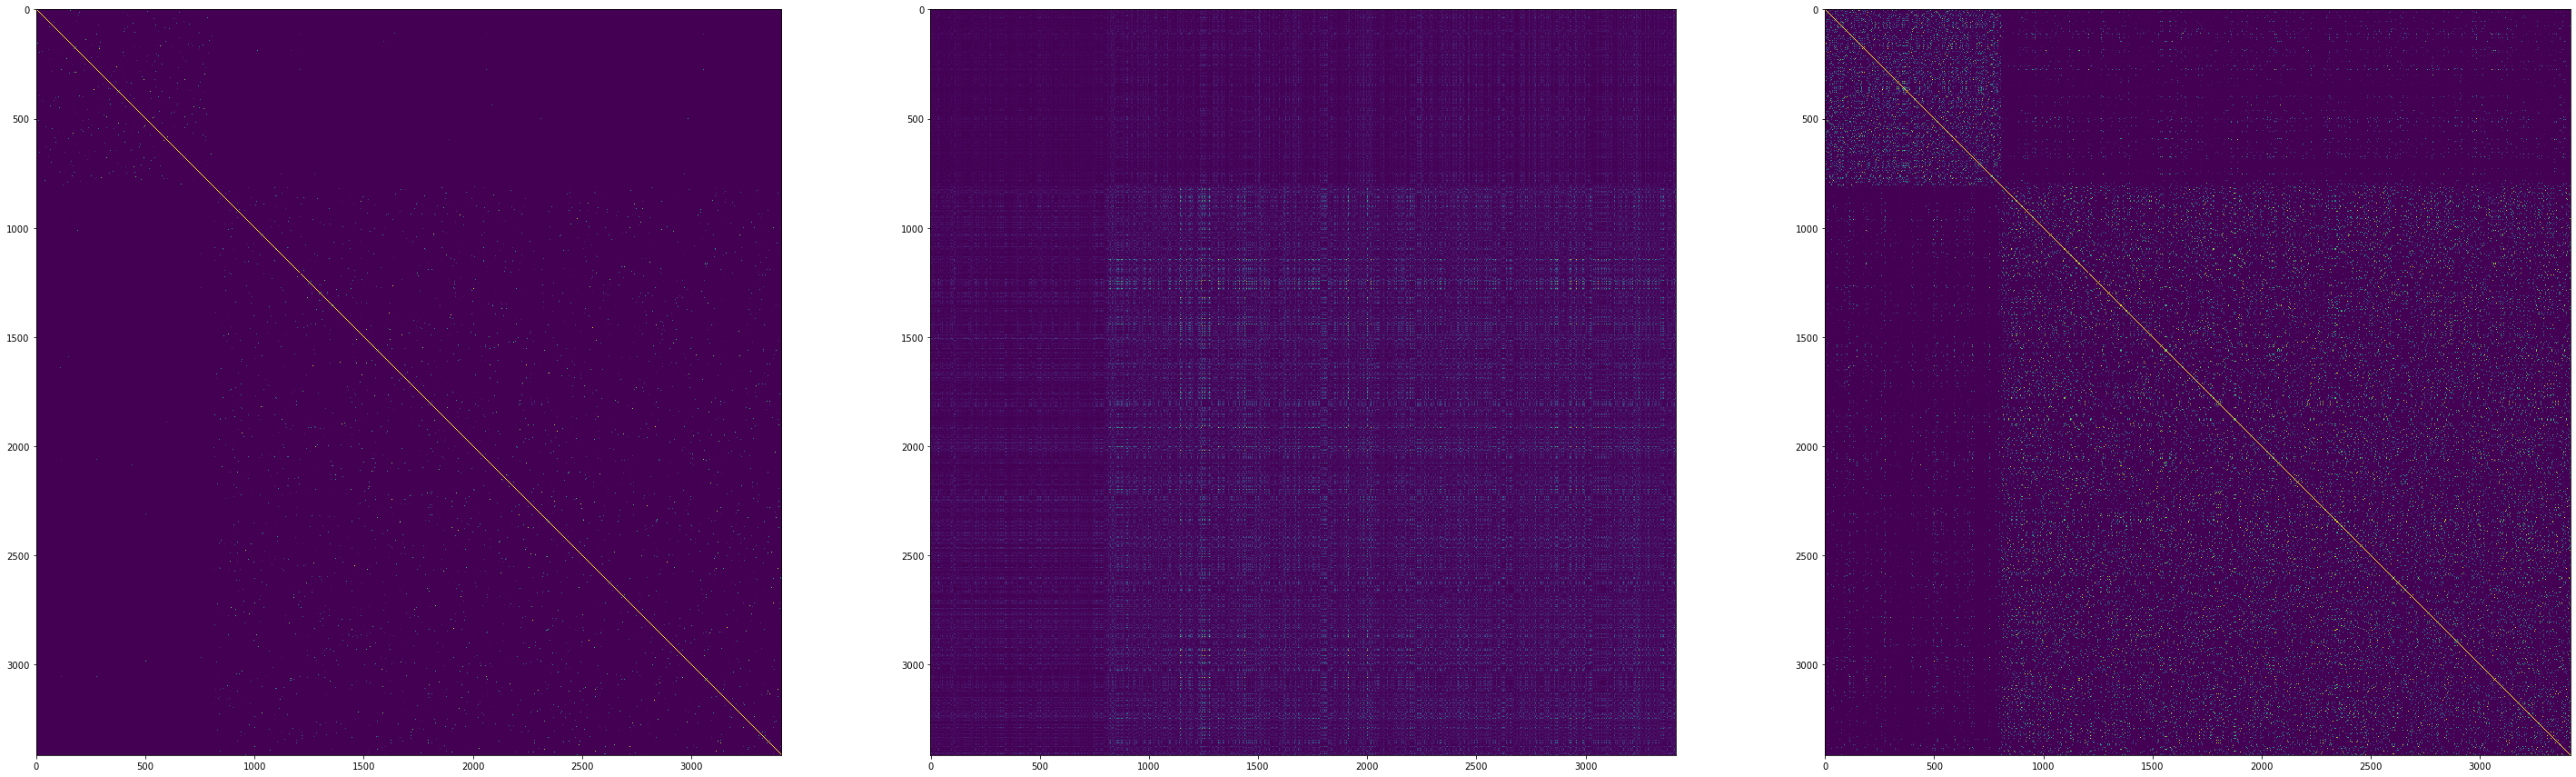

In [59]:
fig, ax = plt.subplots(1,3, sharex=True, figsize=(50,100))
ax[0].imshow(lis[:,:,0])
ax[1].imshow(lis[:,:,1])
ax[2].imshow(lis[:,:,2])
plt.show()

### Simulate infection dynamics
Pseudo code (try to modulize everymajor step)

while not finished{
    - Record disease state progression.
    - Stop simmulation if the outbreak is finished.
    - Introduce interventions
    - Update in population
    - Update in quarantine
    
}


#### Control and Tracking variables
- track_states is a $d2s \times nCat$ matrix containing the distribution of the desease states for a given day.


In [66]:
def isFinished(states,iteration):
    '''Counts the number of individuals who are not suceptible or recovered'''
    return (np.sum(states) == 0 and 10 < iteration)
    
#def isFinished(states,iteration,N):
    #'''Counts the number of suceptible and recovered '''
    #return  (np.sum(states) == N and 10 > iteration) 

In [67]:
d2s = 200 # Number of time steps (days). #200.
nCat = 14 # Diseas state categories (0-13).
track_states = np.zeros((d2s,nCat)) 
op = 1 # ?
thosp = 0 # Total number of hospitalized individuals.

In [68]:
for i in range(d2s):
    '''print("Iteration:",i)
    print(op)
    print(isFinished(track_states[0,[0,6]],N,i))'''
    
    print("Iteration:",i)
    # Record states (disease progession)
    track_states[0,:] = np.histogram(pop_9[:,1], bins=np.arange(nCat+1))[0] 
    
    # Check to see if epidemic has stopped.
    #if isFinished(track_states[0,[0,6]],N,i):
    if isFinished(track_states[i,np.concatenate((np.arange(1,6),np.arange(7,nCat)))],i):
        print("Epidemic ended at iteration:",i)
        break
        
    ##########################################################
    # IDENTIFY CONTAGIOUS AND ACTVE PEOPLE IN DIFFERENT CONTEXTS
    # Contagious in the house and at toilets, in population.  
    # At least presymptomatic AND at most severe.
    cpih = np.logical_and(pop_9[:,1] > 1, pop_9[:,1] < 6)  
    
    # Contagious in the house, in quarantine.
    # At least presymptomatic in quarentine AND at most severe in quarentine.
    cpihq = np.logical_and(pop_9[:,1]>8, pop_9[:,1]<13)    
    
    # Contagious at large in the population (all - for food lines)    
    # Presymptomatic OR (at least symptomatic AND at most mild AND asymptomatic) OR less than 16 years old.
    cpco = np.logical_or(pop_9[:,1]==2, np.logical_and(pop_9[:,1]>2, pop_9[:,1]<5, pop_9[:,4]==1), pop_9[:,5]<16)    
    
    # All at large in the population (all - for food lines). 
    # cpco OR (susceptible or exposed) OR recovered.
    apco = np.logical_or(cpco==True,pop_9[:,1]<2, pop_9[:,1]==6)
    
    # Contagious at large in the population (sedentaries).
    # cpco OR not wanderers.
    cpcos = np.logical_and(cpco==True,pop_9[:,8]==False)
    
    # Contagious at large in the population (wanderers).
    # cpco OR wanderers.
    cpcow = np.logical_and(cpco==True,pop_9[:,8]==True)
        
    ########################################################## 
    # Introduce new interventions on a cue (queue?).
    '''
    if (op==1 & i>1 & (sum(cpih)-sum(cpco))/N>-1)
        iat1=i
        op=0;
        lr1=0.001;
        fblocks=[12,12];
        tr=.25;
        [fshared,lis]=make_obs_180420(fblocks,lr1,lr2,N,hhloc,maxhh,lrtol,ethcor);
        %set rate for people to violate lockdown
        %assume people who violate do so at lr2
        viol_rate=0.05;
        pop(:,9)=(rand(N,1)<viol_rate);
    end
    '''
    
    if ((op == 1) & (i > 1) & (((sum(cpih)-sum(cpco))/N) > 1)):
        #print('Do we hit this update?')
        print("Introduced new interventions on a cue/queue on iteration #",i)
        iat1 = i
        op = 0
        lr1 = 0.001
        fblocks = [12,12]
        tr = 0.25
        fshared, lis = make_obs_180420(fblocks, lr1, lr2, N, hhloc, maxhh, lrtol, ethcor)
        viol_rate = 0.05
        pop_9[:, 8] = np.where(np.random.rand(N) < 0.05, 1, 0)
    ########################################################## 
        
    ########################################################## 
    # UPDATE DISEASE TRACKING.
    # Add day since exposure or symptoms (if not unexposed).
    pop_9[:,3] = pop_9[:,3] + (pop_9[:,1]>0)         
    ########################################################## 
    
    ########################################################## 
    # UPDATE IN POPULATION.
    # Assign people to cases severe enough to be hospitalised. These rates are age speific.
    # We will multiple Verity's rates by 1/(1-0.179) and only allow symptomatic people to be hospitalised,
    # to avoid changing the proportion of asymptomatic infections in the population.
    # We might reasonably assume that only people with infections severe enough to be hospitalised can move on to death,
    # but I will not bother with this for now. Instead, I will simply calculate deaths from the total number of
    # people who were infected at the end of the simulation.  
    
    # Now, they are assigned to severe cases with age-specific probabilities as in Verity,
    # and adjustments for pre-existing conditions as in Tuite. This means that overall severe cases will be
    # slightly higher than Verity predicted if pre-existing conditions are absorbed into their hospitalisation estimates.
    # However, we cannot correct for this without knowing the frequency of pre-existing conditions in Tuite's data.
    # Moreover, the problem may not be large. Hospitalisation estimates are still lower than in Tuite's data.
    # Furthermore, at this point we lack any data at all on how severely COVID-19 may affect populations that
    # are initially malnourished or otherwise in poor condition.  
    
    asp = np.array([0,.000408,.0104,.0343,.0425,.0816,.118,.166,.184])        # Verity et al. hospitalisation
    aspc = np.array([.0101,.0209,.0410,.0642,.0721,.2173,.2483,.6921,.6987])  # Verity et al. corrected for Tuite
    
    # Assigned to recovered state (mild and severe (recovery could be death) symptoms)
    mild_rec = np.random.uniform(0,1,N) > math.exp(0.2*math.log(0.1))   # Liu et al 2020 The Lancet.
    sev_rec = np.random.uniform(0,1,N) > math.exp(math.log(63/153)/12)  # Cai et al.
    pop_9[np.where((pop_9[:,1]==4)+mild_rec==2), 1] = 6                  # Mild symptoms and recovered.
    pop_9[np.where((pop_9[:,1]==5)+sev_rec==2), 1] = 6                   # Severe symptoms and recovered.
    
    pick_sick = np.random.uniform(0,1,N)                            # Get random numbers to determine health states.
    pop_9[(pop_9[:,1]==3)+(pop_9[:,3]==6),1] = 4                    # If 6 days as symptomatic, move to state mild.
    # pop_9[np.where((pop_9[:,1]==3)+(pop_9[:,3]==6)),1] = 4          # If 6 days as symptomatic, move to state mild.
    
    for sci in range(len(asp)-1):
        thosp = thosp + np.sum((pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<asp[sci])+
                               (pop_9[:,5]>=10*sci)+(pop_9[:,5]<(10*sci+1)) == 5)
        pop_9[(pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<asp[sci])+(pop_9[:,5]>=10*sci)+
            (pop_9[:,5]<(10*sci+1)) == 5,1] = 5
        thosp = thosp + np.sum((pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<aspc[sci])+
                               (pop_9[:,5]>=10*sci)+(pop_9[:,5]<(10*sci+1))+(pop_9[:,7]==1)==6)
        pop_9[(pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<asp[sci])+(pop_9[:,5]>=10*sci)+
            (pop_9[:,5]<(10*sci+1))+(pop_9[:,7]==1)==6,1]=5
    
    thosp = thosp + np.sum(((pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<asp[-1])+(pop_9[:,5]>=80))==4)
    pop_9[((pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<asp[-1])+(pop_9[:,5]>=80))==5,1]=5
    thosp = thosp + np.sum(((pop_9[:,1]==4)+(pop_9[:,3]==6)+(pick_sick<aspc[-1])+(pop_9[:,5]>=80)+(pop_9[:,7]==1))==5)
    pop_9[((pop_9[:,1]==4)+(pop_9[:,5]==6)+(pick_sick<aspc[-1]+(pop_9[:,5]>=80)+(pop_9[:,7]==1))==5,1)]=5
          
    # Move to presymptomatic to symptomatic but not yet severe
    idxpresym = ((pop_9[:,1]==2)+(pop_9[:,3] >= pop_9[:,2])) == 2
    pop_9[idxpresym,1] = 3*np.ones((pop_9[idxpresym,1].shape))
    pop_9[idxpresym,3] = np.zeros((pop_9[idxpresym,3].shape))
    
    # Move to exposed to presymptomatic
    pop_9[((pop_9[:,1] == 1)+(pop_9[:,3] >= np.floor(0.5*pop_9[:,2])))==2,1] = 2
    ######################################################### 
    
    ##########################################################  
    # UPDATE IN QUARANTINE. See notes from population.
    # Assign to recovered state using mild_rec and sev_rec from above.
    # Set state and days in current state of Individuals with mild symptoms in quarentine and recovered to 
    # suceptible(0) and recovered (13)
    idxrecovmild = ((pop_9[:,1]==11)+(mild_rec))==2
    pop_9[idxrecovmild,1] = 13*np.ones((pop_9[idxrecovmild,1].shape))
    pop_9[idxrecovmild,3] = np.zeros((pop_9[idxrecovmild,1].shape))    

    # Set state and days in current state of Individuals with severe symptoms in quarentine and recovered to 
    # suceptible(0) and recovered (13)
    idxrecovsevere = ((pop_9[:,1]==12)+(sev_rec))==2
    pop_9[idxrecovsevere,1] = 13*np.ones((pop_9[idxrecovsevere,1].shape))
    pop_9[idxrecovsevere,3] = np.zeros((pop_9[idxrecovsevere,1].shape))    

    # Assign people to cases severe enough to be hospitalised (using pick_sick from above)
    # First, everyone who is symptomatic in quarentine (10) progresses to at least mild in quarentine (11).
    pop_9[((pop_9[:,1]==10)+(pop_9[:,3]==6))==2,2] = 11
    
    for sci in range(len(asp)-1):
        thosp = thosp + np.sum((pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<asp[sci])+
                               (pop_9[:,5]>=10*sci)+(pop_9[:,5]<(10*sci+1)) == 5)
        pop_9[(pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<asp[sci])+(pop_9[:,5]>=10*sci)+
            (pop_9[:,5]<(10*sci+1)) == 5,1] = 12
        thosp = thosp + np.sum((pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<aspc[sci])+
                               (pop_9[:,5]>=10*sci)+(pop_9[:,5]<(10*sci+1))+(pop_9[:,7]==1)==6)
        pop_9[(pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<asp[sci])+(pop_9[:,5]>=10*sci)+
            (pop_9[:,5]<(10*sci+1))+(pop_9[:,7]==1)==6,1]=12

    thosp = thosp + np.sum(((pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<asp[-1])+(pop_9[:,5]>=80))==4)
    pop_9[((pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<asp[-1])+(pop_9[:,5]>=80))==5,1]=12
    thosp = thosp + np.sum(((pop_9[:,1]==11)+(pop_9[:,3]==6)+(pick_sick<aspc[-1])+(pop_9[:,5]>=80)+(pop_9[:,7]==1))==5)
    pop_9[((pop_9[:,1]==11)+(pop_9[:,5]==6)+(pick_sick<aspc[-1]+(pop_9[:,5]>=80)+(pop_9[:,7]==1))==5,1)]=12    
    
    # Move to presymptomatic to symptomatic but not yet severe
    idxpresym = ((pop_9[:,1]==9)+(pop_9[:,3] >= pop_9[:,2])) == 2
    pop_9[idxpresym,1] = 10*np.ones((pop_9[idxpresym,1].shape))
    pop_9[idxpresym,3] = np.zeros((pop_9[idxpresym,3].shape))
    
    # Move to exposed to presymptomatic
    pop_9[((pop_9[:,1] == 8)+(pop_9[:,3] >= np.floor(0.5*pop_9[:,2])))==2,1] = 7    
    
    #if sum(pop(:,2)==2)>0
    #    return
    #end    
    ##########################################################
    
    ##########################################################
    # COMPUTE INFEECTED PEOPLE PER HOUSEHOLD.
    # There is some bug in here.
    infh = np.histogram(cpih,np.arange(maxhh+1))[0]   # All infected in house and at toilets, population 
    infhq = np.histogram(cpihq,np.arange(maxhh+1))[0] # All infected in house, quarantine 
    infl = np.histogram(cpco,np.arange(maxhh+1))[0]   # presymptomatic and asymptomatic for food lines
    allfl = np.histogram(apco,np.arange(maxhh+1))[0]  # All people in food lines
    infls = np.histogram(cpcos,np.arange(maxhh+1))[0] # All sedentaries for local transmission
    inflw = np.histogram(cpcow,np.arange(maxhh+1))[0] # All wanderers for local transmission    
    ##########################################################    
    
    ##########################################################
    # COMPUTE INFECTION PROBABILITIES FOR EACH PERSON BY HOUSEHOLD
    # Probability for members of each household to contract from their housemates
    cfh = (1-(1-twh))**np.array(infh)       # In population.
    cfhq = (1-(1-twh))**np.array(infhq)     # In quarantine.
    # CHECK THIS MI-DRUN !!!
    
    # Compute proportions infecteds at toilets and in food lines
    pitoil = (tshared.dot(infh))/(tshared.dot(pph)) # bug in infh calculation
    pifl = (fshared.dot(infl))/(fshared.dot(allfl)) # bug in infl calculation
    
    # Compute transmission at toilets by household (There is an erro when calculating pitoil and pitfl above).
    tmp = 0
    for i in np.arange(7) :
        tmp += (math.factorial(6-i)*math.factorial(i))**-1*(1-pitoil)**(6-i) *(pitoil**i)*(1-aip*tr)**i
    trans_at_toil = np.sum(1-math.factorial(6)*tmp)      
    
    # Compute transmission in food lines by household.
    # Assume each person goes to the food line once per day on 75% of days.
    # Other days someone brings food to them (with no additional contact).   
    trans_in_fl = 0
    for i in np.arange(3) :
        trans_in_fl += (0.75)*(1-2*(math.factorial(2-i)*math.factorial(i))**-1*((1-pifl)**(2-i))*(pifl**i)*(1-aip*tr)**i)    
    
    # Households in quarantine don't get these exposures, but that is taken care of below
    # because this is applied only to susceptibles in the population with these, we can calculate
    # the probability of all transmissions that calculated at the household level.
    pthl = 1-(1-cfh)*(1-trans_at_toil)*(1-trans_in_fl)
    
    # Transmissions during movement around the residence must be calculated at the individual level,
    # because they do not depend on what movement radius the individual uses. So...
    # Compute expected contacts with infected individuals for individuals that use small and large movement radii.
    lr1_exp_contacts = lis[:,:,0].dot(infls)+lis[:,:,1].dot(inflw)
    lr2_exp_contacts = lis[:,:,1].dot(infls)+lis[:,:,2].dot(inflw)    

    # But contacts are roughly Poisson distributed (assuming a large population), so transmission rates are:
    trans_for_lr1 = 1-np.exp(-lr1_exp_contacts*aip*tr)
    trans_for_lr2 = 1-np.exp(-lr2_exp_contacts*aip*tr)    
    
    # Now, assign the appropriate local transmission rates to each person.
    local_trans = trans_for_lr1[pop_9[:,0].astype(int)]*(1-pop_9[:,8])+trans_for_lr2[pop_9[:,0].astype(int)]*(1-pop_9[:,8])
    
    # Finally, compute the full per-person infection probability within households, at toilets and food lines.
    full_inf_prob = 1-(1-pthl[pop_9[:,0].astype(int)])*(1-local_trans)
    ##########################################################    
    
    ##########################################################    
    # ASSIGN NEW INFECTIONS
    new_inf = full_inf_prob>np.random.uniform(0,1,N)                # Find new infections by person, population.
    pop_9[:,1] = pop_9[:,1]+(1-np.sign(pop_9[:,1]))*new_inf         # Impose infections, population.
    new_inf = cfhq[pop_9[:,0].astype(int)]>np.random.uniform(0,1,N) # Find new infections by person, quarantine
    pop_9[:,1] = pop_9[:,1]+(pop_9[:,1]==7)*new_inf                 # Impose infections, quarantine.
    ##########################################################    
    
    ##########################################################    
    # MOVE HOUSEHOLDS TO QUARANTINE
    # Identify symptomatic people in population
    sip =  np.logical_and(np.logical_and(pop_9[:,1]>2, pop_9[:,1]<6,
                                         pop_9[:,4]==0),pop_9[:,5]>=16)*(np.random.uniform(0,1,N)<siprob)
    
    # Identify symptomatic households
    symphouse = np.unique(pop_9[np.where(sip==1),0])    
    
    # Move households to quarantine
    pop_9[np.in1d(pop_9[:,0],symphouse),1] += 7
    ##########################################################
    
    ##########################################################
    # MOVE INDIVIDUALS BACK TO POPULATION when they have not shed for cleardays.
    # Currently, the model does not include a mechanism for sending people back from quarantine
    # if they never get the infection. This may not matter if the infection spreads in quarantine,
    # but we will have to watch to see if some people get stuck in state 7.
    pop_9[np.logical_and(pop_9[:,1]==13, pop_9[:,3]>=7),1] = 6
    
    ##########################################################
    
    ##########################################################
    # TRACK INFECTION THROUGH SPACE
    if np.remainder(i,5) == 0 :
        plt.scatter(hhloc[:,0], hhloc[:,1],s=(1+infh)**2,c=hheth, marker='o')
        plt.pause(0.05)

        plt.show()     
    ##########################################################

Iteration: 0


C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:199: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in add
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in greater


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Epidemic ended at iteration: 11


In [ ]:
# % %TRACK INFECTION THROUGH TIME
# figure(2)
# plot(track_states(1:i,1:7))
# legend('susc','exp','asy','sym','mrec','sev','rec')
# % 
# figure(3)
# plot(track_states(1:i,2:6))
# legend('exp','asy','sym','mrec','sev')
# % 
# % figure(4)
# % plot(track_states(1:i,8:14))
# % legend('susc','exp','asy','sym','mrec','sev','rec')
# % 
# % figure(5)
# % plot(sum(track_states(1:i,8:14),2))
# % legend('total quarantine')
# % 
# % figure(6)
# % plot(sum(track_states(1:i,1:7),2))
# % legend('total camp')

# %COLLECT USEFUL DATA
# [peak_infection,days_to_peak_infection]=max(sum(track_states(:,[2:6,9:13]),2));
# [peak_hospitalisation,days_to_peak_hospitalisation]=max(sum(track_states(:,[6,13]),2));
# [peak_quarantine,days_to_peak_quarantine]=max(sum(track_states(:,8:14),2));
# total_proportion_infected=track_states(i,7)/N;
# epidemic_over=(sum(track_states(i,[1,7]))==N);

# %The old model had apparatus for calculating age and sex-specific death
# %rates. I have not moved that to this model, for two reasons. First, unless
# %the model has some behaviour by which the infection rate differs among age
# %groups, and this model doesn't, then the total number of infected people
# %and the total hospitalisations tell us everything we need to know about
# %deaths. That is, if we reduce infections by x%, we will reduce deaths by
# %x%, unless swamping the hospitals affects the death rate, in which case
# %the number of concurrent hospitalisations tell us what we need to know
# %Second, we really don't know anything about what kinds of death rates to
# %expect in an undernourished, impoverished poplation with inadequate
# %medical facilities. Prelilminary data from US minority populations
# %suggests that these things matter. So, anything we do with death rates at
# % this point is really just making stuff up. Above I have turned ICU and
# % death rates to -1 because other functions want them, but we can ignore
# % them for now.